# Pozivanje Fortran i C koda iz Pythona

In [1]:
%pylab inline
from IPython.display import Image

Populating the interactive namespace from numpy and matplotlib


Prednost Pythona je što je fleksibilan i jednostavan za programiranje. Vrijeme potrebno za postavljanje novog znanstvenog izračuna je stoga kratko. Za određene vrste izračuna Python (i bilo koji drugi interpreter) može biti vrlo spor. Posebno je teško učinkovito izvesti iteracije preko velikih nizova.

Takvi se izračuni mogu implementirati u kompajliranom jeziku kao što je C ili Fortran. U Pythonu je relativno lako pozvati `library` s  C ili Fortran kodom. U ovom predavanju ćemo pogledati kako to učiniti.

 i zašto...

In [2]:
# Image(filename='slike/performanse.jpg')

## ZADATAK    

Odredite raspodjelu potencijala u prostoru prema slici i prikažite ga slikom. Generirajte kod koristeći Python, Fortran i Cython. Usporedite vremena izvođenja. Koristite raster 50x50 i iterativni postupak dok odstupanje koraka ne bude manje od 0,1%.
Uputa: Laplaceova jednadžba koja određuje potencijal u prostoru može se dobro aproksimirati kao srednja vrijednost četiri okolna čvora.

In [3]:
# Image(filename='slike/potencijal.jpg')

## Python kod:

In [4]:
import numpy as np

In [5]:
def python_raster(r):
    
    with np.nditer(r, flags=['multi_index'], op_flags=['writeonly']) as it:
        for x in it:
            # If it's the first row or last row or first or last column
            if (it.multi_index[0] == 0 or it.multi_index[0] == size + 1 or it.multi_index[1] == 0 or it.multi_index[1] == size + 1):
                pass
            else:
                tmp = (raster[it.multi_index[0]][it.multi_index[1] - 1] + raster[it.multi_index[0] - 1][it.multi_index[1]] + raster[it.multi_index[0]][it.multi_index[1] + 1] + raster[it.multi_index[0] + 1][it.multi_index[1]]) / 4
                x[...] = (raster[it.multi_index[0]][it.multi_index[1] - 1] + raster[it.multi_index[0] - 1][it.multi_index[1]] + raster[it.multi_index[0]][it.multi_index[1] + 1] + raster[it.multi_index[0] + 1][it.multi_index[1]]) / 4


In [6]:
#Set size
size = 50

# Create raster
raster = np.zeros((size + 2, size + 2))

# Set the first row to 100
raster[0] = np.full((1, size + 2), 100)

# Copy to the old raster
new_raster = raster.copy()

# Init the first raster
python_raster(raster)

while not (np.allclose(raster, new_raster, rtol=1e-03)):
    # atol + rtol*absolute(a2)
    new_raster = raster.copy()
    python_raster(raster)

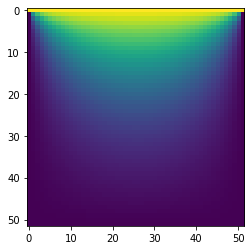

In [7]:
import matplotlib.pyplot as plt

plt.imshow(raster)

### Vrijeme potrebno za izvodenje:

In [8]:
%%timeit

# Clean raster
clean_raster = np.zeros((size + 2, size + 2))
clean_raster[0] = np.full((1, size + 2), 100)

python_raster(clean_raster)

9.64 ms ± 128 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Cython kod

In [9]:
%load_ext cython

In [10]:
%%cython -a

import numpy as np

def cython_raster(double[:,::1]r):
    cdef size = 50
    
    with np.nditer(r, flags=['multi_index'], op_flags=['writeonly']) as it:
        for x in it:
            # If it's the first row or last row or first or last column
            if (it.multi_index[0] == 0 or it.multi_index[0] == size + 1 or it.multi_index[1] == 0 or it.multi_index[1] == size + 1):
                pass
            else:
                x[...] = (r[it.multi_index[0]][it.multi_index[1] - 1] + r[it.multi_index[0] - 1][it.multi_index[1]] + r[it.multi_index[0]][it.multi_index[1] + 1] + r[it.multi_index[0] + 1][it.multi_index[1]]) / 4


In [11]:
#Set size
size = 50

# Create raster
raster_cython = np.zeros((size + 2, size + 2))

# Set the first row to 100
raster_cython[0] = np.full((1, size + 2), 100)

# Copy to the old raster
new_raster_cython = raster_cython.copy()

# Init the first raster
cython_raster(raster_cython)

while not (np.allclose(raster_cython, new_raster_cython, rtol=1e-03)):
    # atol + rtol*absolute(a2)
    new_raster_cython = raster_cython.copy()
    cython_raster(raster_cython)

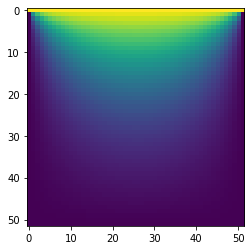

In [12]:
import matplotlib.pyplot as plt

plt.imshow(raster_cython)

### Vrijeme potrebno za izvodenje:

In [13]:
%%timeit

# Clean raster
clean_raster = np.zeros((size + 2, size + 2))
clean_raster[0] = np.full((1, size + 2), 100)

cython_raster(clean_raster)

1.75 ms ± 6.69 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Fortran kod

In [14]:
%%file laplace.f
c File laplace.f
       subroutine laplace(a, b)
       double precision a(50 + 2, 50 + 2)
       double precision b(50 + 2, 50 + 2)
        
       integer :: n = 50
        
cf2py  intent(in) :: a
cf2py  intent(out) :: a
cf2py  intent(hide) :: n

       DO i=0, 51
            do j=0, 51
                IF ((i==0).or.(i==(n+1)).or.(j==0).or.(j==(n+1))) THEN
                    b(i,j) = a(i,j)
                ELSE
                    b(i,j) = (a(i,j-1)+a(i-1,j)+a(i,j+1)+a(i+1,j))/4
                END IF
            END DO
       END DO
       end

Overwriting laplace.f


Kompajlirajm kod u modul:

In [15]:
!f2py -c laplace.f -m laplace

running build
running config_cc
unifing config_cc, config, build_clib, build_ext, build commands --compiler options
running config_fc
unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
running build_src
build_src
building extension "laplace" sources
f2py options: []
f2py:> /tmp/tmp62q2embs/src.linux-x86_64-3.9/laplacemodule.c
creating /tmp/tmp62q2embs/src.linux-x86_64-3.9
Reading fortran codes...
	Reading file 'laplace.f' (format:fix,strict)
Post-processing...
	Block: laplace
			Block: laplace
Post-processing (stage 2)...
Building modules...
	Building module "laplace"...
		Constructing wrapper function "laplace"...
		  a = laplace(a,b)
	Wrote C/API module "laplace" to file "/tmp/tmp62q2embs/src.linux-x86_64-3.9/laplacemodule.c"
  adding '/tmp/tmp62q2embs/src.linux-x86_64-3.9/fortranobject.c' to sources.
  adding '/tmp/tmp62q2embs/src.linux-x86_64-3.9' to include_dirs.
copying /home/lukas/anaconda3/envs/env_TRM/lib/python3.9/site-packages/numpy/f2py/src

Removing build directory /tmp/tmp62q2embs


In [16]:
import laplace

#Set size
size = 50

# Create raster
raster_fortran = np.zeros((size + 2, size + 2))

# Set the first row to 100
raster_fortran[0] = np.full((1, size + 2), 100)

# Copy to the old raster
new_raster_fortran = raster_fortran.copy()

# Init the first raster
print(raster_fortran.shape)
laplace.laplace(raster_fortran, raster_fortran)

while not (np.allclose(raster_fortran, new_raster_fortran, rtol=1e-03)):
    # atol + rtol*absolute(a2)
    new_raster_fortran = raster_fortran.copy()
    laplace.laplace(raster_fortran, raster_fortran)

(52, 52)


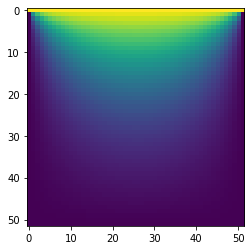

In [17]:
import matplotlib.pyplot as plt

plt.imshow(raster_cython)

### Vrijeme potrebno za izvodenje:

In [18]:
%%timeit

import laplace

# Clean raster
clean_raster = np.zeros((size + 2, size + 2))
clean_raster[0] = np.full((1, size + 2), 100)

laplace.laplace(raster_fortran, raster_fortran);

10.2 µs ± 149 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
